In [1]:
import json 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import random
import os
import time
from sklearn.model_selection import *
from sklearn.metrics import f1_score
from transformers import *
import matplotlib.pyplot as plt

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'hfl/chinese-macbert-base',
    'max_len': 512, 
    'epochs': 4,
    'train_bs': 16, 
    'valid_bs': 16,
    'lr': 1e-5, 
    'num_workers': 4,
    'accum_iter': 1, 
    'weight_decay': 1e-6, 
    'device': 1,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['seed'])

torch.cuda.set_device(CFG['device'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_df =  pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [5]:
test_df['task'] = test_df['id'].apply(lambda x:{'a':0,'b':1}[x.split('_')[-1]])
test_df

,source,target,id,type,len1,len2,task
0,北京顺义2个地区调整为低风险地区,黑龙江省大庆市中风险地区清零全域调为低风险,ss0_a,ss,16,21,0
1,库里夺冠希望渺茫！荣誉或就此而止，退役后进不了历史前十,维金斯：勇士文化是不同的这可能是我生涯最开心的阶段,ss1_a,ss,27,25,0
2,过年了，过年了！,就地过年的你，许愿吗？,ss2_a,ss,8,14,0
3,你见过被噎死的蛇吗？这条蛇自作自受吞下庞然大物把自己给撑死了！,这种瓜有人从来没见过，这里却做全瓜宴,ss3_a,ss,31,20,0
4,如果你喜欢关注足球赛事、喜欢讨论赛事战术打法、了解豪门球队背后的历史渊源、喜爱投资足彩竞彩…...,大家好，我是小狼！前天利物浦客场3:1击败铁锤帮西汉姆联，红军打进的第二个进球太漂亮了，就像...,ss4_a,ss,148,150,0
...,...,...,...,...,...,...,...
29817,郑秀文1972年出生在香港，是上世纪90年代人们的回忆，当时在香港是具有代表性的一位女歌手，...,就一眼爱变成了一种天赋 不自觉能和你笑抱你哭 我为你有了旅途 不管离天涯几步 我都不在乎 这...,ll5005_b,ll,985,2412,1
29818,本季MVP候选人之一的火箭「胡子」JamesHarden（哈登），今天在与国王赛后受访时表示...,威少不在乎MVP新浪体育讯北京时间12月12日，据美媒体报道，本赛季开始以来，雷霆队当家球星...,ll5006_b,ll,554,415,1
29819,在全球范围内，对新冠病毒的限制正在收紧，这给航运业，尤其是对海员换班带来了新的压力。 随着...,预警！马上杀到阜阳！做好防护！（点击查看）刚刚！成功！市二院医生跪了那么久…（点击查看） 我...,ll5007_b,ll,1414,4928,1
29820,苏提达不如诗妮娜那么能屈能伸，在昨天的活动上，苏提达等到了机会可以和泰王一起出席活动，她却控...,在诗妮娜贵妃风光复宠之后，苏提达王后确实变得比之前低调了很多，大家也很少看到她公开现身的画...,ll5008_b,ll,1087,410,1


In [6]:
tokenizer = BertTokenizer.from_pretrained(CFG['model'])

In [7]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text1 = self.df.source.values[idx]
        text2 = self.df.target.values[idx]
        
        task = self.df.task.values[idx]
        
        return text1, text2, task

In [8]:
def collate_fn(data):
    input_ids, attention_mask, token_type_ids = [], [], []
    text = tokenizer([x[0] for x in data], text_pair=[x[1] for x in data], padding='max_length', truncation=True, max_length=CFG['max_len'], return_tensors='pt')
    input_ids = text['input_ids']
    attention_mask = text['attention_mask']
    token_type_ids = text['token_type_ids']
    label = torch.LongTensor([x[2] for x in data])
    return input_ids, attention_mask, token_type_ids, label

In [9]:
class Model(nn.Module):

    def __init__(self, CFG):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained(CFG['model'])
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 2)
        self.fc2 = nn.Linear(self.bert.config.hidden_size, 2)
 
    def forward(self, input_ids, attention_mask, token_type_ids):
        text = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[1]
        y1 = self.fc1(text)
        y2 = self.fc2(text)
        return y1, y2

In [11]:
models = []
model =  Model(CFG).to(device)

for i in range(5):
    model.load_state_dict(torch.load('{}_fold_{}.pt'.format(CFG['model'].split('/')[-1], i)))
    model.eval()
    models.append(model)

In [12]:
test_set = MyDataset(test_df)
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], collate_fn=collate_fn, shuffle=False, num_workers=CFG['num_workers'])

In [13]:
y_pred = []

with torch.no_grad():

    tk = tqdm(test_loader, total=len(test_loader), position=0, leave=True)
    
    for step, (input_ids, attention_mask, token_type_ids, tasks) in enumerate(tk):
        
        input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)

        outputs = []
        
        for i in range(len(models)):
            output1, output2 = models[i](input_ids, attention_mask, token_type_ids)
            output = torch.zeros_like(output1)
            
            for j in range(len(tasks)):
                task = tasks[j]

                if task == 0:
                    output[j] = output1[j]
                else:
                    output[j] = output2[j]

            outputs.append(output.softmax(1).cpu().numpy())

        output = np.mean(outputs, 0)
#         print(output.shape)
        
        y_pred.extend(output)

100%|██████████| 932/932 [27:49<00:00,  1.79s/it]


In [14]:
y_pred = np.array(y_pred)[:,1]

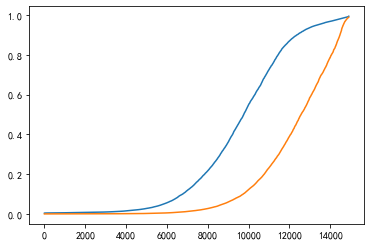

In [33]:
plt.plot(sorted(y_pred[test_df['task']==0]))
plt.plot(sorted(y_pred[test_df['task']==1]))
plt.show()

In [34]:
test_df['label'] = y_pred

test_df

,source,target,id,type,len1,len2,task,label
0,北京顺义2个地区调整为低风险地区,黑龙江省大庆市中风险地区清零全域调为低风险,ss0_a,ss,16,21,0,0.644375
1,库里夺冠希望渺茫！荣誉或就此而止，退役后进不了历史前十,维金斯：勇士文化是不同的这可能是我生涯最开心的阶段,ss1_a,ss,27,25,0,0.045304
2,过年了，过年了！,就地过年的你，许愿吗？,ss2_a,ss,8,14,0,0.392077
3,你见过被噎死的蛇吗？这条蛇自作自受吞下庞然大物把自己给撑死了！,这种瓜有人从来没见过，这里却做全瓜宴,ss3_a,ss,31,20,0,0.010468
4,如果你喜欢关注足球赛事、喜欢讨论赛事战术打法、了解豪门球队背后的历史渊源、喜爱投资足彩竞彩…...,大家好，我是小狼！前天利物浦客场3:1击败铁锤帮西汉姆联，红军打进的第二个进球太漂亮了，就像...,ss4_a,ss,148,150,0,0.044656
...,...,...,...,...,...,...,...,...
29817,郑秀文1972年出生在香港，是上世纪90年代人们的回忆，当时在香港是具有代表性的一位女歌手，...,就一眼爱变成了一种天赋 不自觉能和你笑抱你哭 我为你有了旅途 不管离天涯几步 我都不在乎 这...,ll5005_b,ll,985,2412,1,0.003529
29818,本季MVP候选人之一的火箭「胡子」JamesHarden（哈登），今天在与国王赛后受访时表示...,威少不在乎MVP新浪体育讯北京时间12月12日，据美媒体报道，本赛季开始以来，雷霆队当家球星...,ll5006_b,ll,554,415,1,0.040593
29819,在全球范围内，对新冠病毒的限制正在收紧，这给航运业，尤其是对海员换班带来了新的压力。 随着...,预警！马上杀到阜阳！做好防护！（点击查看）刚刚！成功！市二院医生跪了那么久…（点击查看） 我...,ll5007_b,ll,1414,4928,1,0.014400
29820,苏提达不如诗妮娜那么能屈能伸，在昨天的活动上，苏提达等到了机会可以和泰王一起出席活动，她却控...,在诗妮娜贵妃风光复宠之后，苏提达王后确实变得比之前低调了很多，大家也很少看到她公开现身的画...,ll5008_b,ll,1087,410,1,0.499267


In [35]:
test_df.loc[test_df['task']==0,'label'] = (test_df[test_df['task']==0]['label']>0.5).astype('int') #后处理，0.5可调为更好的阈值
test_df.loc[test_df['task']==1,'label'] = (test_df[test_df['task']==1]['label']>0.5).astype('int')

In [36]:
sub = pd.read_csv('sample_submission.csv')
sub

,id,label
0,ss0_a,1
1,ss1_a,0
2,ss2_a,0
3,ss3_a,0
4,ss4_a,0
...,...,...
29817,ss4925_b,0
29818,ss4926_b,1
29819,ss4927_b,1
29820,ss4928_b,1


In [37]:
for i in tqdm(range(len(sub))):
    id_ = sub.loc[i,'id']
    tmp = test_df[test_df.id==id_]
#     print(tmp)
    sub.loc[i,'label'] = tmp.label.values

100%|██████████| 29822/29822 [00:56<00:00, 523.25it/s]


In [38]:
sub

,id,label
0,ss0_a,1.0
1,ss1_a,0.0
2,ss2_a,0.0
3,ss3_a,0.0
4,ss4_a,0.0
...,...,...
29817,ss4925_b,0.0
29818,ss4926_b,0.0
29819,ss4927_b,0.0
29820,ss4928_b,0.0


In [39]:
sub.to_csv('sub.csv',index=False)